In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

In [2]:
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20))
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)
    return series[..., np.newaxis].astype(np.float32)

In [3]:
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$"):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bx", markersize=10)
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "ro")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])


def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 20, 0, 0.05])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

    
def plot_multiple_forecast(x, y, y_pred):
    n_steps = x.shape[1]
    ahead = y.shape[1]
    plot_series(x[0, :, 0])
    plt.plot(np.arange(n_steps, n_steps + ahead), y[0, :, 0], 
             'ro-', label='Actual')
    plt.plot(np.arange(n_steps, n_steps + ahead), y_pred[0, :, 0], 
             'bx-', label='Forecast', markersize=10)
    plt.axis([0, n_steps + ahead, -1, 1])
    plt.legend(fontsize=14)

In [4]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 10)
x_train = series[:7000, :n_steps]
x_valid = series[7000:9000, :n_steps]
x_test = series[9000:, :n_steps]

y = np.empty((10000, n_steps, 10))

for step_ahead in range(1, 10 + 1):
    y[..., step_ahead - 1] = series[..., step_ahead:step_ahead + n_steps, 0]

y_train = y[:7000]
y_valid = y[7000:9000]
y_test = y[9000:]

In [5]:
def last_time_step_mse(y_true, y_pred):
    return keras.metrics.mean_squared_error(y_true[:, -1], y_pred[:, -1])

LSTM

In [6]:
model = keras.models.Sequential([
    keras.layers.RNN(keras.layers.LSTMCell(20), 
                     return_sequences=True, 
                     input_shape=[None, 1]),
    keras.layers.RNN(keras.layers.LSTMCell(20), 
                     return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

In [7]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.LSTM(20, return_sequences=True, 
                      input_shape=[None, 1]),
    keras.layers.LSTM(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss='mse', optimizer='adam', 
              metrics=[last_time_step_mse])
history = model.fit(x_train, y_train, epochs=20, 
                    validation_data=(x_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 5s 9ms/step - loss: 0.0760 - last_time_step_mse: 0.0615 - val_loss: 0.0554 - val_last_time_step_mse: 0.0364
Epoch 2/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0480 - last_time_step_mse: 0.0283 - val_loss: 0.0427 - val_last_time_step_mse: 0.0222
Epoch 3/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0391 - last_time_step_mse: 0.0181 - val_loss: 0.0367 - val_last_time_step_mse: 0.0157
Epoch 4/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0350 - last_time_step_mse: 0.0151 - val_loss: 0.0334 - val_last_time_step_mse: 0.0132
Epoch 5/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0325 - last_time_step_mse: 0.0133 - val_loss: 0.0314 - val_last_time_step_mse: 0.0121
Epoch 6/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0308 - last_time_step_mse: 0.0122 - val_loss: 0.0298 - val_last_time_step_mse: 0.0112
Epoch 7/20
219/219 [========

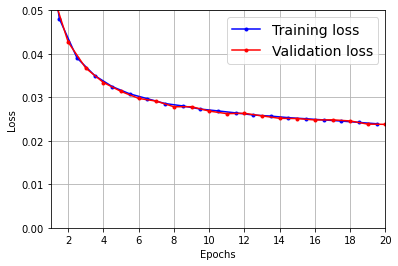

In [8]:
plot_learning_curves(history.history['loss'], history.history['val_loss'])
plt.show()

In [9]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
x_new, y_new = series[:, :50, :], series[:, 50:, :]
y_pred = model.predict(x_new)[:, -1][..., np.newaxis]

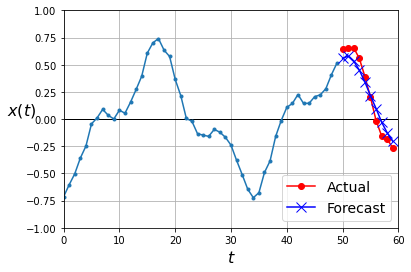

In [10]:
plot_multiple_forecast(x_new, y_new, y_pred)
plt.show()

GRU

In [11]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.GRU(20, return_sequences=True, 
                      input_shape=[None, 1]),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss='mse', optimizer='adam', 
              metrics=[last_time_step_mse])
history = model.fit(x_train, y_train, epochs=20, 
                    validation_data=(x_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 3s 8ms/step - loss: 0.0738 - last_time_step_mse: 0.0655 - val_loss: 0.0538 - val_last_time_step_mse: 0.0450
Epoch 2/20
219/219 [==============================] - 1s 7ms/step - loss: 0.0476 - last_time_step_mse: 0.0367 - val_loss: 0.0441 - val_last_time_step_mse: 0.0326
Epoch 3/20
219/219 [==============================] - 1s 7ms/step - loss: 0.0417 - last_time_step_mse: 0.0301 - val_loss: 0.0390 - val_last_time_step_mse: 0.0275
Epoch 4/20
219/219 [==============================] - 1s 7ms/step - loss: 0.0368 - last_time_step_mse: 0.0243 - val_loss: 0.0339 - val_last_time_step_mse: 0.0202
Epoch 5/20
219/219 [==============================] - 1s 7ms/step - loss: 0.0326 - last_time_step_mse: 0.0180 - val_loss: 0.0312 - val_last_time_step_mse: 0.0164
Epoch 6/20
219/219 [==============================] - 1s 7ms/step - loss: 0.0306 - last_time_step_mse: 0.0155 - val_loss: 0.0294 - val_last_time_step_mse: 0.0143
Epoch 7/20
219/219 [========

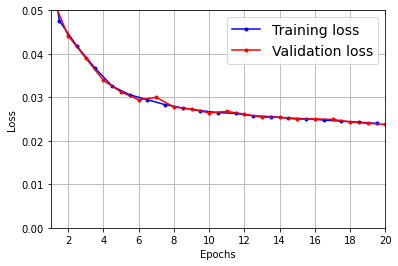

In [12]:
plot_learning_curves(history.history['loss'], history.history['val_loss'])
plt.show()

In [13]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
x_new, y_new = series[:, :50, :], series[:, 50:, :]
y_pred = model.predict(x_new)[:, -1][..., np.newaxis]

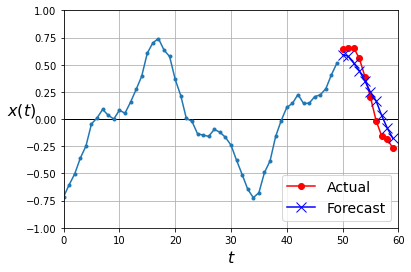

In [14]:
plot_multiple_forecast(x_new, y_new, y_pred)
plt.show()

Using One-Dimensional Convolutional Layer to Process Sequences

In [15]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Conv1D(filters=20, kernel_size=4, 
                        strides=2, padding='valid', 
                        input_shape=[None, 1]),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss='mse', optimizer='adam', 
              metrics=[last_time_step_mse])
history = model.fit(x_train, y_train[:, 3::2], epochs=20, 
                    validation_data=(x_valid, y_valid[:, 3::2]))

Epoch 1/20
219/219 [==============================] - 4s 8ms/step - loss: 0.0681 - last_time_step_mse: 0.0601 - val_loss: 0.0477 - val_last_time_step_mse: 0.0396
Epoch 2/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0414 - last_time_step_mse: 0.0340 - val_loss: 0.0367 - val_last_time_step_mse: 0.0285
Epoch 3/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0338 - last_time_step_mse: 0.0257 - val_loss: 0.0307 - val_last_time_step_mse: 0.0218
Epoch 4/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0282 - last_time_step_mse: 0.0184 - val_loss: 0.0259 - val_last_time_step_mse: 0.0152
Epoch 5/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0249 - last_time_step_mse: 0.0143 - val_loss: 0.0246 - val_last_time_step_mse: 0.0141
Epoch 6/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0234 - last_time_step_mse: 0.0125 - val_loss: 0.0227 - val_last_time_step_mse: 0.0115
Epoch 7/20
219/219 [========

WaveNet

In [16]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=[None, 1])
])
for rate in (1, 2, 4, 8) * 2:
    model.add(keras.layers.Conv1D(filters=20, kernel_size=2, padding='causal', 
                                  activation='relu', dilation_rate=rate))
model.add(keras.layers.Conv1D(filters=10, kernel_size=1))

model.compile(loss='mse', optimizer='adam', metrics=[last_time_step_mse])
history = model.fit(x_train, y_train, epochs=20, 
                    validation_data=(x_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 3s 9ms/step - loss: 0.0668 - last_time_step_mse: 0.0543 - val_loss: 0.0365 - val_last_time_step_mse: 0.0231
Epoch 2/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0323 - last_time_step_mse: 0.0192 - val_loss: 0.0294 - val_last_time_step_mse: 0.0166
Epoch 3/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0283 - last_time_step_mse: 0.0156 - val_loss: 0.0269 - val_last_time_step_mse: 0.0145
Epoch 4/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0261 - last_time_step_mse: 0.0136 - val_loss: 0.0254 - val_last_time_step_mse: 0.0131
Epoch 5/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0248 - last_time_step_mse: 0.0124 - val_loss: 0.0244 - val_last_time_step_mse: 0.0122
Epoch 6/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0240 - last_time_step_mse: 0.0117 - val_loss: 0.0232 - val_last_time_step_mse: 0.0108
Epoch 7/20
219/219 [========

In [17]:
class GatedActivationUnit(keras.layers.Layer):
    def __init__(self, activation='tanh', **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
    
    def call(self, inputs):
        n_filters = inputs.shape[-1] // 2
        linear_output = self.activation(inputs[..., :n_filters])
        gate = keras.activations.sigmoid(inputs[..., n_filters:])
        return self.activation(linear_output) * gate

In [18]:
def wavenet_residual_block(inputs, n_filters, dilation_rate):
    z = keras.layers.Conv1D(2 * n_filters, kernel_size=2, padding='causal', 
                            dilation_rate=dilation_rate)(inputs)
    z = GatedActivationUnit()(z)
    z = keras.layers.Conv1D(n_filters, kernel_size=1)(z)
    return keras.layers.Add()([z, inputs]), z

In [19]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

n_layers_per_block = 3
n_blocks = 1
n_filters = 32
n_outputs = 10

inputs = keras.layers.Input(shape=[None, 1])
z = keras.layers.Conv1D(n_filters, kernel_size=2, padding='causal')(inputs)
skip_to_last = []

for dilation_rate in [2 ** i for i in range(n_layers_per_block)] * n_blocks:
    z, skip = wavenet_residual_block(z, n_filters, dilation_rate)
    skip_to_last.append(skip)
    
z = keras.activations.relu(keras.layers.Add()(skip_to_last))
z = keras.layers.Conv1D(n_filters, kernel_size=1, activation='relu')(z)
y_proba = keras.layers.Conv1D(n_outputs, kernel_size=1, activation='softmax')(z)

model = keras.models.Model(inputs=[inputs], outputs=[y_proba])

In [20]:
model.compile(loss='mse', optimizer='adam', metrics=[last_time_step_mse])
history = model.fit(x_train, y_train, epochs=20, 
                    validation_data=(x_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 3s 10ms/step - loss: 0.1300 - last_time_step_mse: 0.1260 - val_loss: 0.1229 - val_last_time_step_mse: 0.1199
Epoch 2/20
219/219 [==============================] - 2s 8ms/step - loss: 0.1222 - last_time_step_mse: 0.1178 - val_loss: 0.1217 - val_last_time_step_mse: 0.1189
Epoch 3/20
219/219 [==============================] - 2s 8ms/step - loss: 0.1215 - last_time_step_mse: 0.1172 - val_loss: 0.1214 - val_last_time_step_mse: 0.1186
Epoch 4/20
219/219 [==============================] - 2s 8ms/step - loss: 0.1212 - last_time_step_mse: 0.1169 - val_loss: 0.1211 - val_last_time_step_mse: 0.1183
Epoch 5/20
219/219 [==============================] - 2s 9ms/step - loss: 0.1210 - last_time_step_mse: 0.1167 - val_loss: 0.1209 - val_last_time_step_mse: 0.1181
Epoch 6/20
219/219 [==============================] - 2s 9ms/step - loss: 0.1208 - last_time_step_mse: 0.1165 - val_loss: 0.1208 - val_last_time_step_mse: 0.1179
Epoch 7/20
219/219 [=======